In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.visualization.scatter import Scatter

from net_flow_opt.utils import components, structure
from net_flow_opt.network import  Activity, System
from net_flow_opt.model import DiscreteModel
from net_flow_opt.callbacks import TrackPerformance
from net_flow_opt.sampling import GroupingStructureSampling


Main parameters of the experiment are declared here.

In [2]:
pop_size = 200
termination = ('n_gen', 300)
seed = 43348
eps = 1e-3

The cells below repeat the experiment with a different number of resources.

In [3]:
def experiment(resources):

    system = System(structure, components)

    activities = [Activity(component) for component in system.components]

    problem = DiscreteModel(system=system, resources=resources)

    T = 200
    dates = np.array([a.t for a in activities])
    d_t = np.vstack([- dates, T - dates])
    i = np.argmax(np.abs(d_t), axis=0)
    d_t = d_t[i, np.arange(d_t.shape[1])]

    ref_point = np.array([
        system.regular_flow * T,
        np.sum([a.h(d_t[i] + eps) for i, a in enumerate(activities)])
    ])

    algorithm = NSGA2(
        sampling=GroupingStructureSampling(),
        crossover=SBX(prob=0.9, eta=3.0, vtype=float, repair=RoundingRepair()),
        mutation=PM(prob=0.9, eta=3.0, vtype=float, repair=RoundingRepair()),
        pop_size=pop_size,
        eliminate_duplicates=True,
        callback=TrackPerformance(ref_point=ref_point),
    )

    res = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=termination,
        seed=seed,
        save_history=True,
    )

    return res

In [4]:
for resources in range(2, 8):
    res = experiment(resources)

    # save data
    df = pd.DataFrame(res.opt.get("F"), columns=['IC', 'LF'])
    df.to_csv(f'../data/discrete_r{resources}.csv', index=False)

    df = pd.DataFrame(np.array(res.algorithm.callback.data['hv']), columns=['HV'])
    df.index.name = 'iter'
    df.to_csv(f'../data/discrete_hv_r{resources}.csv')

    with open(f'../data/discrete_r{resources}', 'wb') as f:
        dill.dump(res, f)

    print(f"Experiment with r={resources} completed.")

/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:50: RuntimeWarning: invalid value encountered in power
  d = 1.0 - (np.power(val, mut_pow))
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/michele/.cache/pypoetry/virtualenvs/net-flow-op

Experiment with r=2 completed.


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/michele/.cache

Experiment with r=3 completed.


/home/michele/.cache/pypoetry/virtualenvs/net-flow-opt-va4GqYfJ-py3.10/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Experiment with r=4 completed.
Experiment with r=5 completed.
Experiment with r=6 completed.
Experiment with r=7 completed.


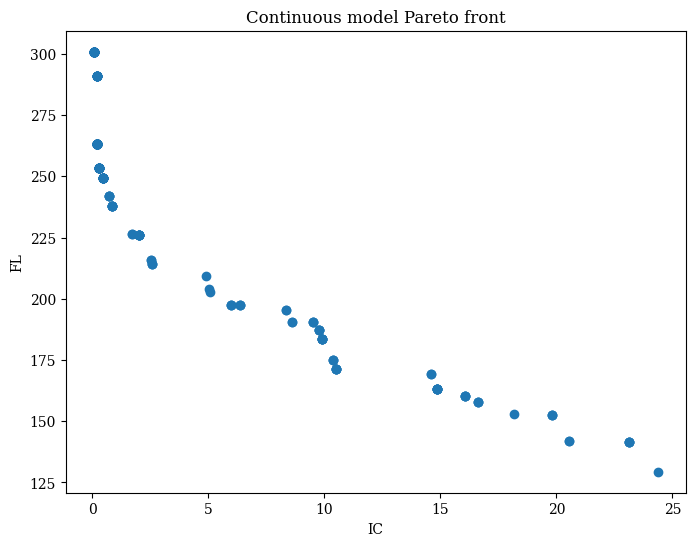

In [5]:
F = res.opt.get("F")
plot = Scatter(
    title="Continuous model Pareto front",
    labels=['IC', 'FL']
)
plot.add(F)
plot.show()

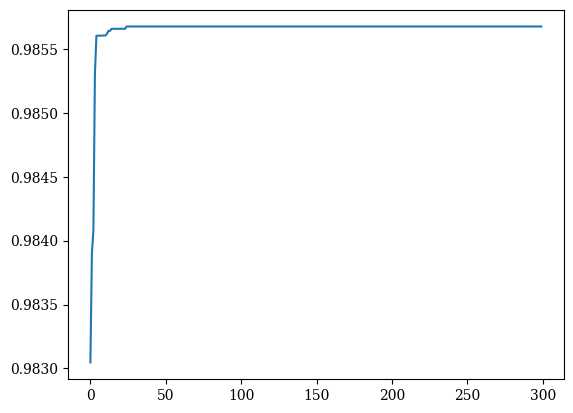

In [6]:

hv = np.array(res.algorithm.callback.data['hv'])

plt.plot(hv)